<a href="https://colab.research.google.com/github/Nyamadie/Loss-analysis/blob/main/New_Channels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
from google.colab import drive
drive.mount('')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving patient_data (11).csv to patient_data (11).csv


In [ ]:
import pickle
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from dtaidistance import dtw
import scipy.signal

# Data Preprocessing

The data has already been cleaned so all we have to do is process it for our use case.

In [ ]:
# File paths
pickle_file_path = ''
patient_file_path = ''

with open(pickle_file_path, 'rb') as file:
    signal_data = pickle.load(file)

df = pd.read_csv(patient_file_path)
filtered_df = df[df['Data QA'] >= 0.4].dropna(subset=['z_score'])
filenames = filtered_df['filenames'].tolist()

ppg_signals_df = signal_data['file_data']

# Extract signals corresponding to 10 filenames
selected_filenames = filenames[:30]
selected_signals = []
for filename in selected_filenames:
    if filename in ppg_signals_df:
        selected_signals.append(ppg_signals_df[filename]['env_scaled'].values)
    else:
        print(f"Warning: {filename} not found in PPG signals.")

# Resampling

This resampling was done with the help of peak finders and interpolation.

In simple terms, interpolation creates new data points within the range of a set of known data points. The goal is to predict or infer values in-between the existing points based on certain assumptions or models.

In [ ]:
def process_signals(ppg_signals_df, selected_filenames, target_length=50):
    # Initialize new channels
    stretched_signals = {}  # Channel 1
    stretching_factors = {}  # Channel 2

    for filename in selected_filenames:
        if filename not in ppg_signals_df:
            print(f"Warning: {filename} not found.")
            continue

        env_scaled = ppg_signals_df[filename]['env_scaled'].values
        peaks, _ = scipy.signal.find_peaks(env_scaled, distance=target_length//2)
        segments = []

        for i in range(len(peaks) - 1):
            # Extract each heartbeat
            start, end = peaks[i], peaks[i + 1]
            heartbeat = env_scaled[start:end]

            # Calculate the stretching factor
            original_length = len(heartbeat)
            stretch_factor = original_length / target_length

            # Interpolate to normalize to target length
            x_original = np.linspace(0, 1, original_length)
            x_resampled = np.linspace(0, 1, target_length)
            interpolator = interp1d(x_original, heartbeat, kind='linear')
            resampled_heartbeat = interpolator(x_resampled)

            segments.append(resampled_heartbeat)

            # Store results
            if filename not in stretched_signals:
                stretched_signals[filename] = []
                stretching_factors[filename] = []

            stretched_signals[filename].append(resampled_heartbeat)
            stretching_factors[filename].append(stretch_factor)

    return stretched_signals, stretching_factors

In [ ]:
# Verify that the new channels have been created
print(f"Number of segments created: {len(stretched_signals)}")
print(f"Average stretch factor: {np.mean(stretch_factors)}")

# Store the results in a DataFrame for further analysis
new_channels_df = pd.DataFrame({
    'stretched_signal': stretched_signals,
    'stretch_factor': stretch_factors
})

Number of segments created: 3792
Average stretch factor: 4.998261982537303


# Applying the Function

In [ ]:
# Apply the function
stretched_signals, stretching_factors = process_signals(ppg_signals_df, selected_filenames)

In [ ]:
# Example: Inspect one file's results
example_file = selected_filenames[26]
example_resampled = stretched_signals[example_file]
example_factors = stretching_factors[example_file]

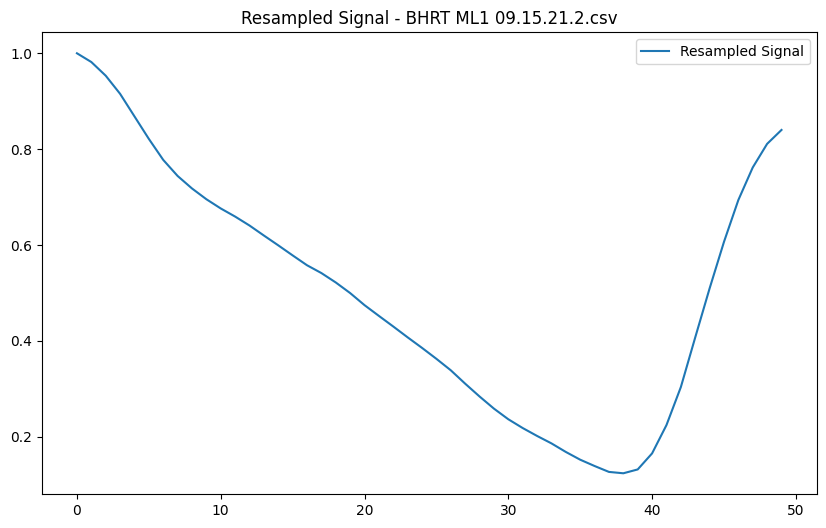

In [ ]:
# Plot one resampled signal
plt.figure(figsize=(10, 6))
plt.plot(example_resampled[0], label='Resampled Signal')
plt.title(f"Resampled Signal - {example_file}")
plt.legend()
plt.show()

# Visualization

## Peak Finder Visualization

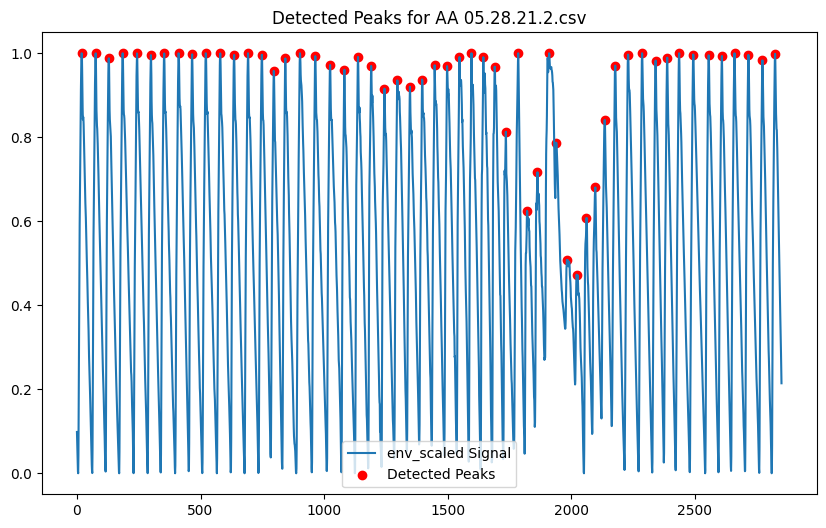

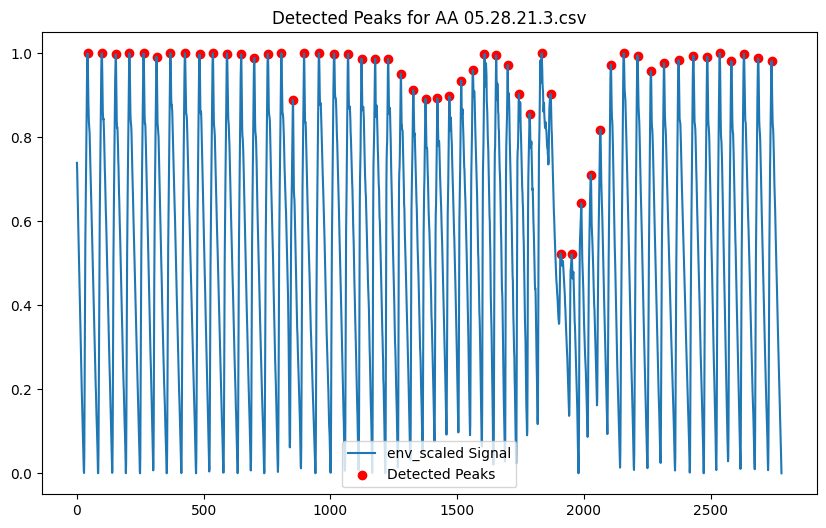

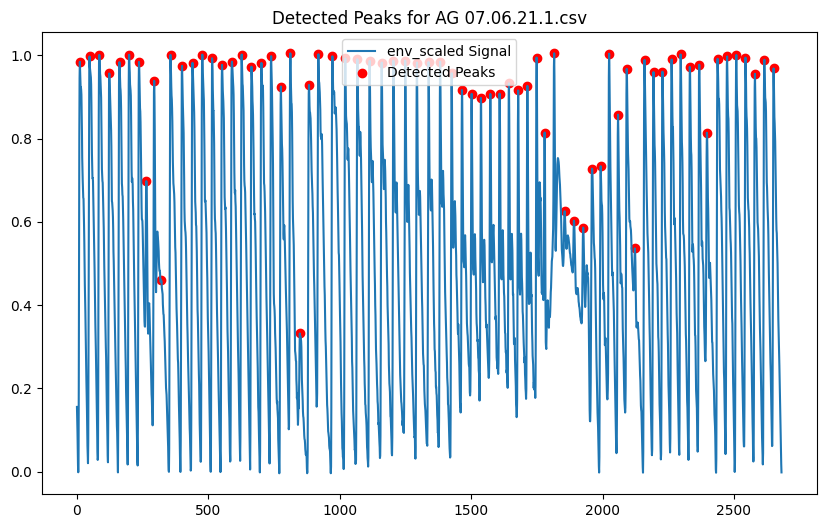

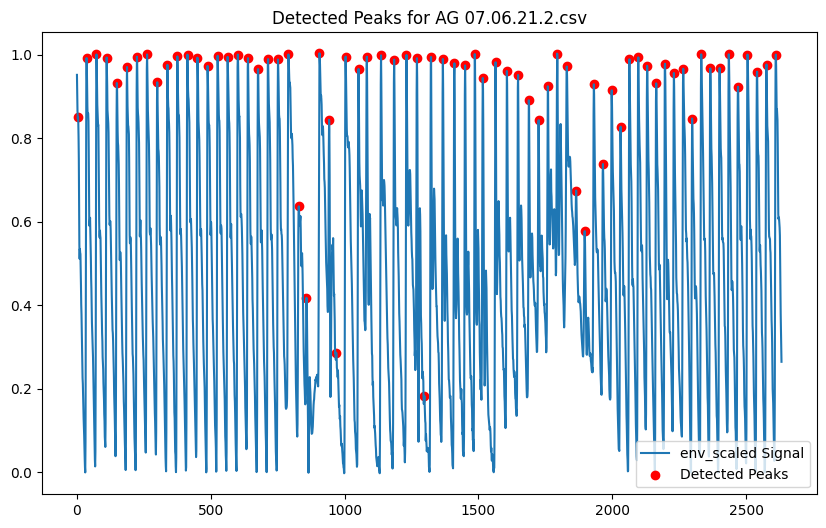

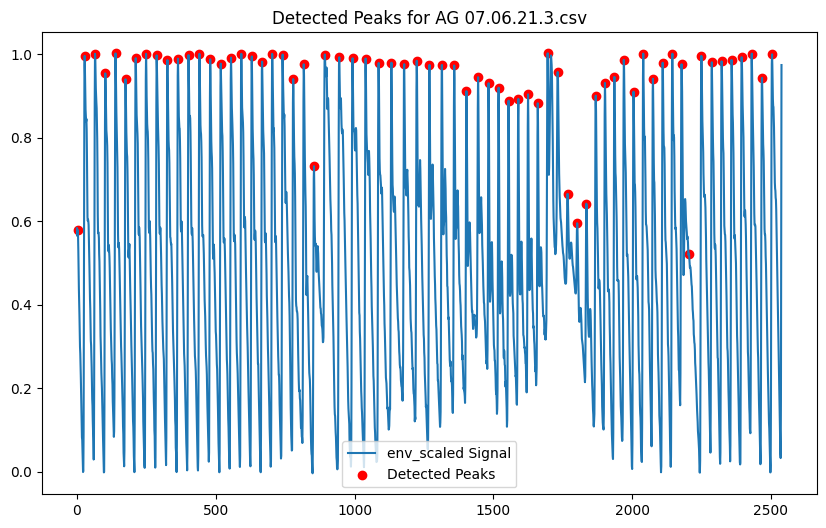

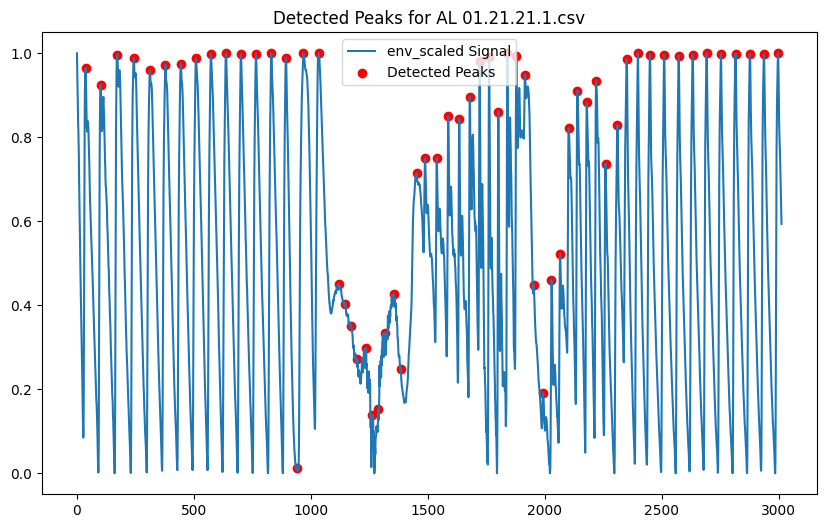

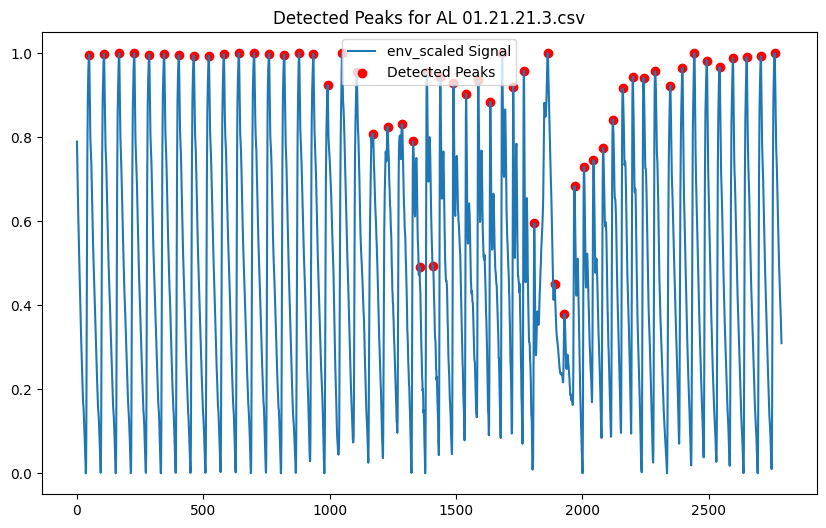

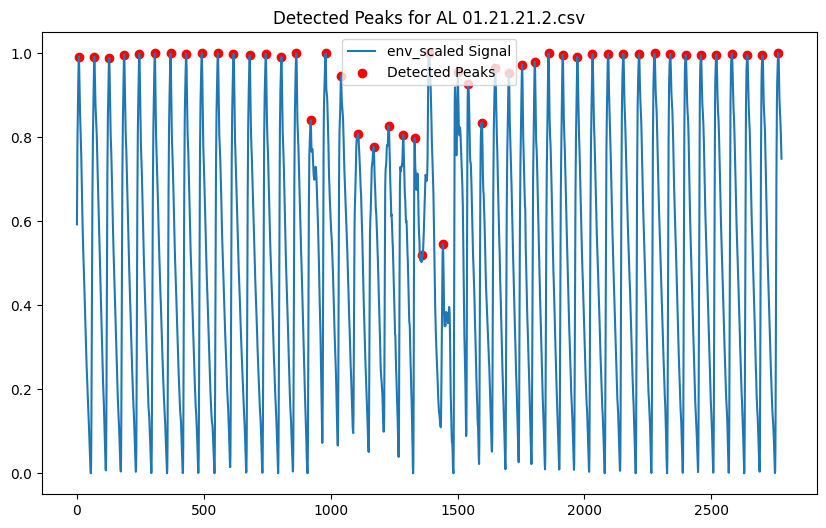

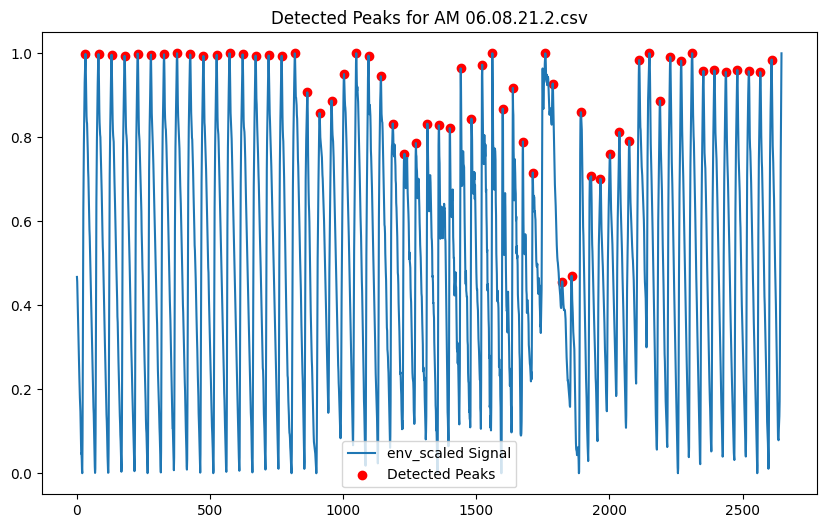

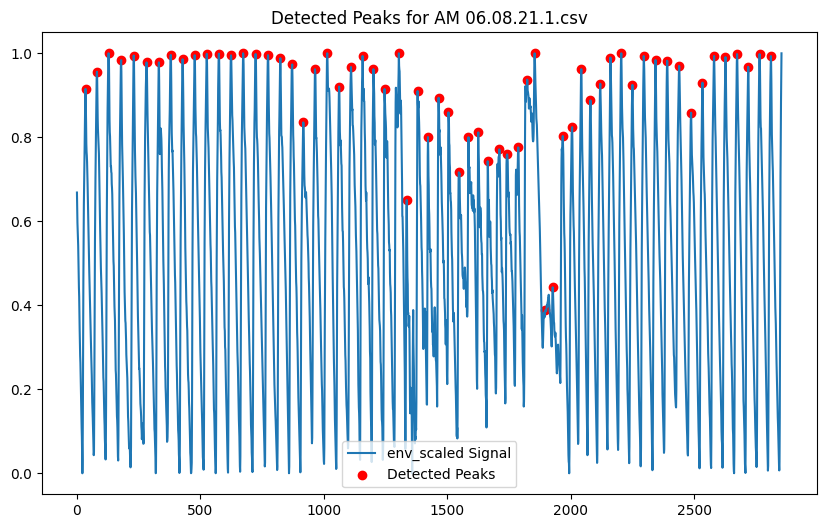

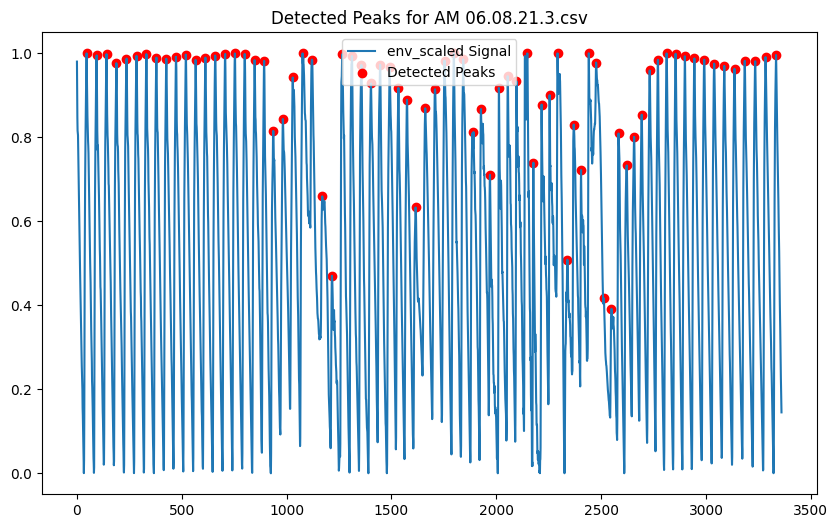

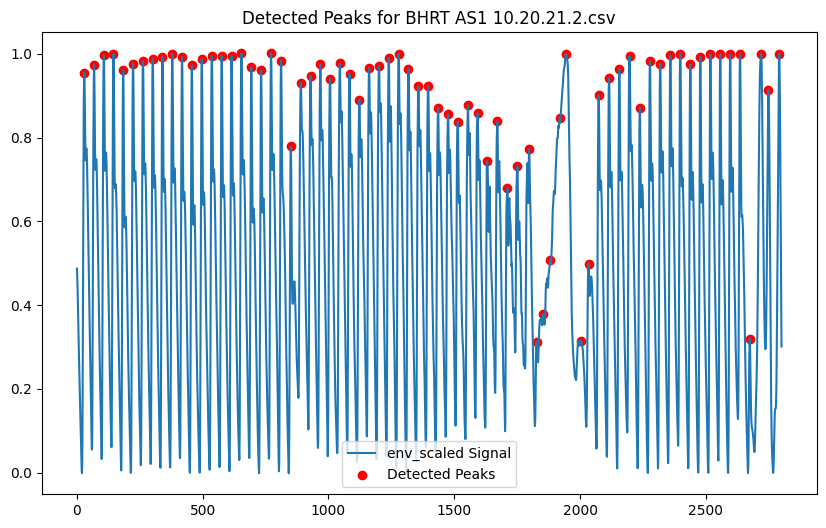

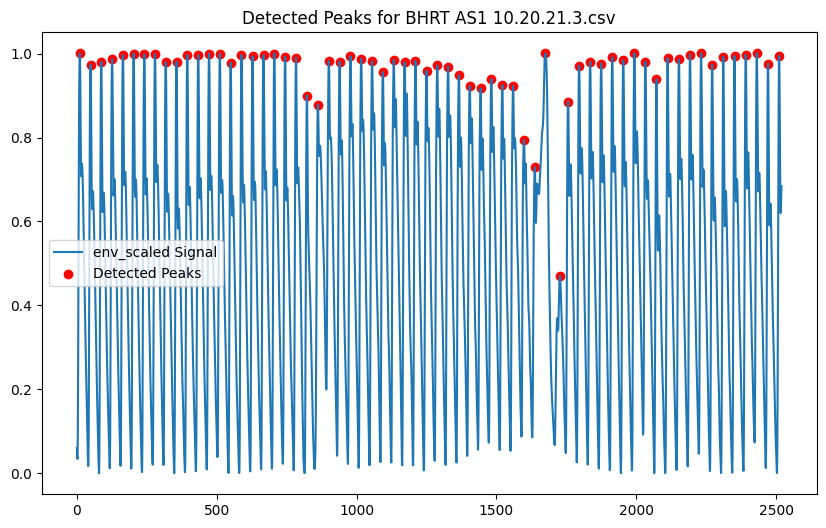

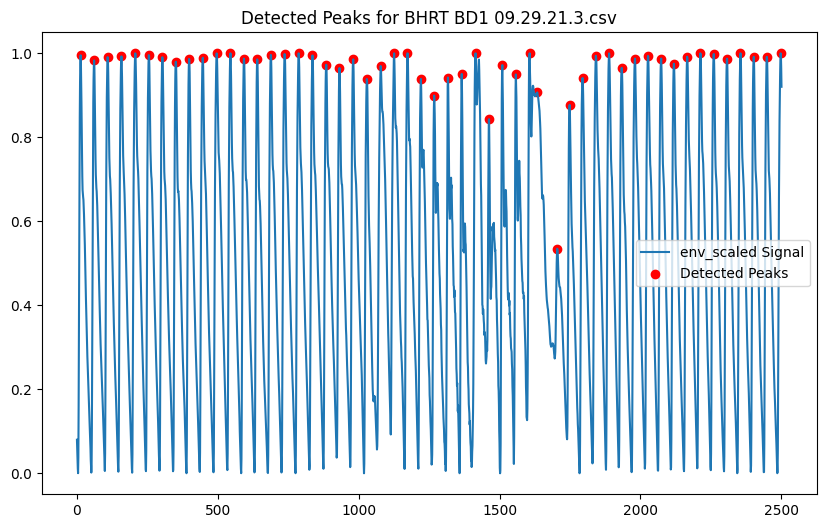

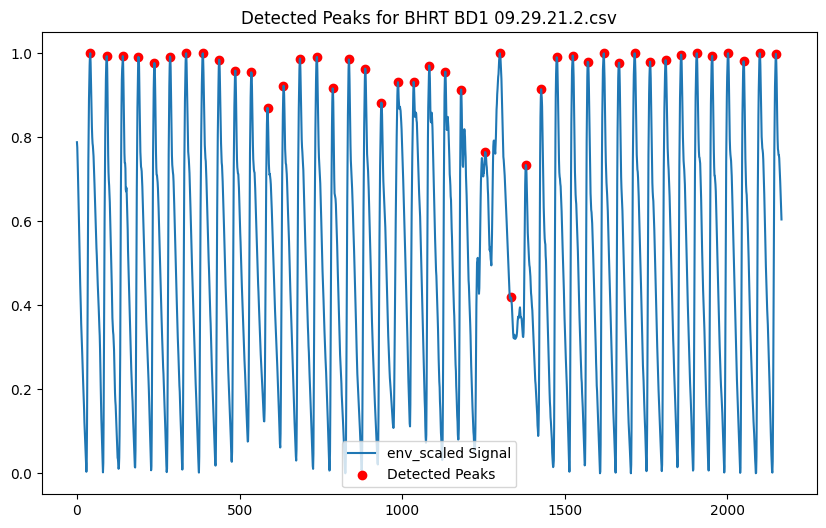

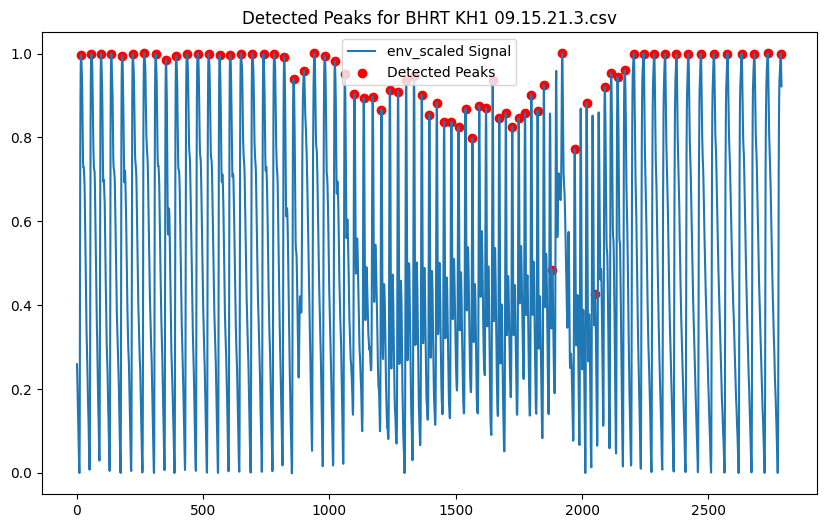

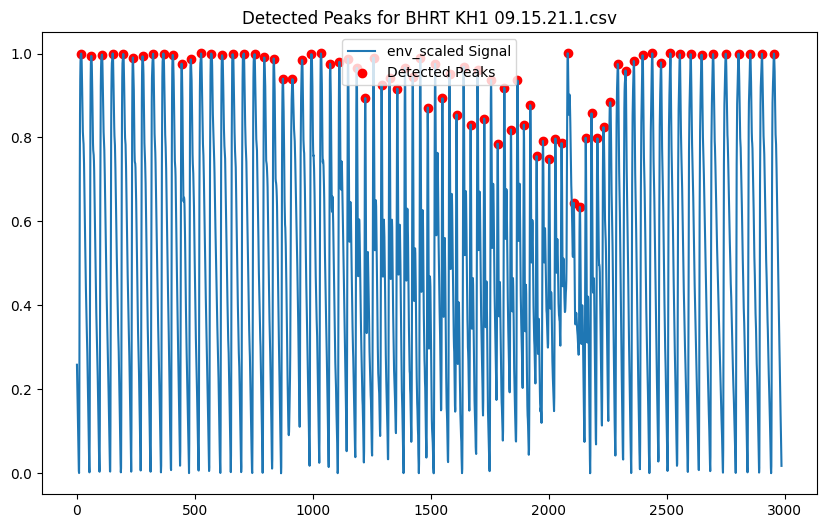

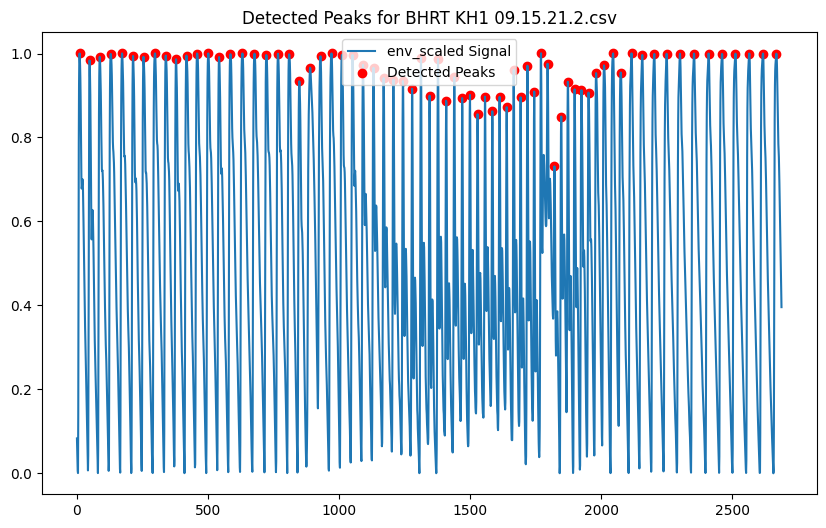

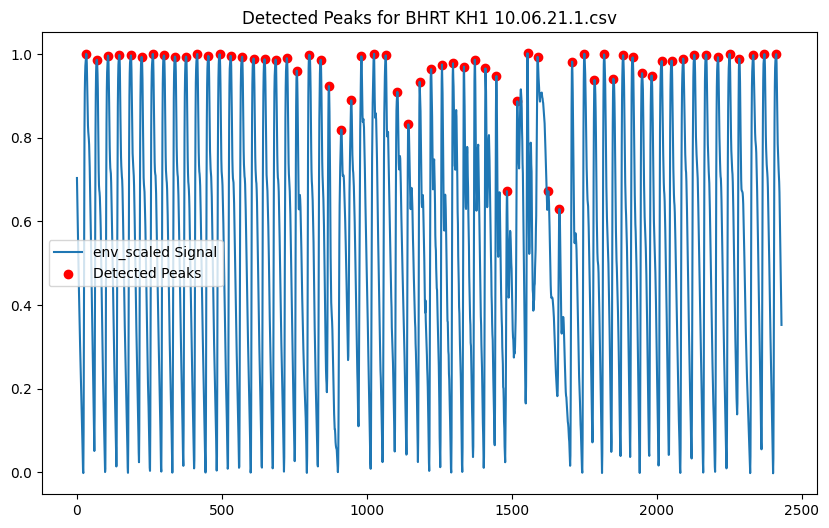

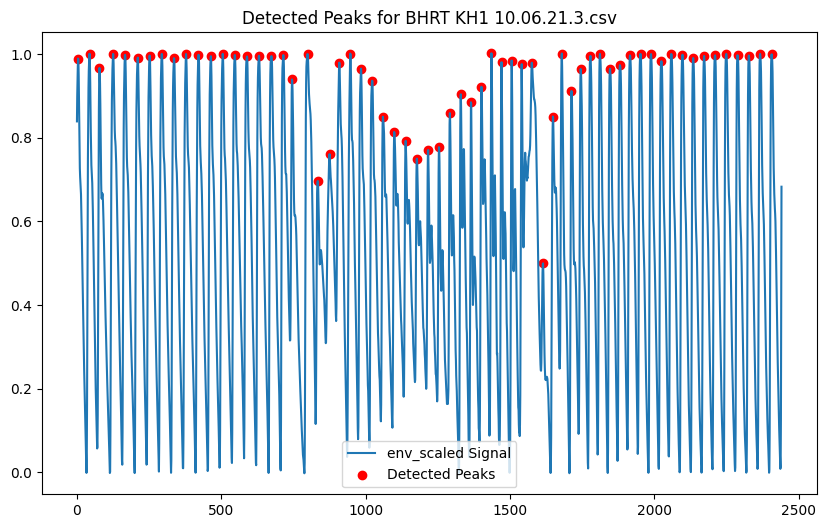

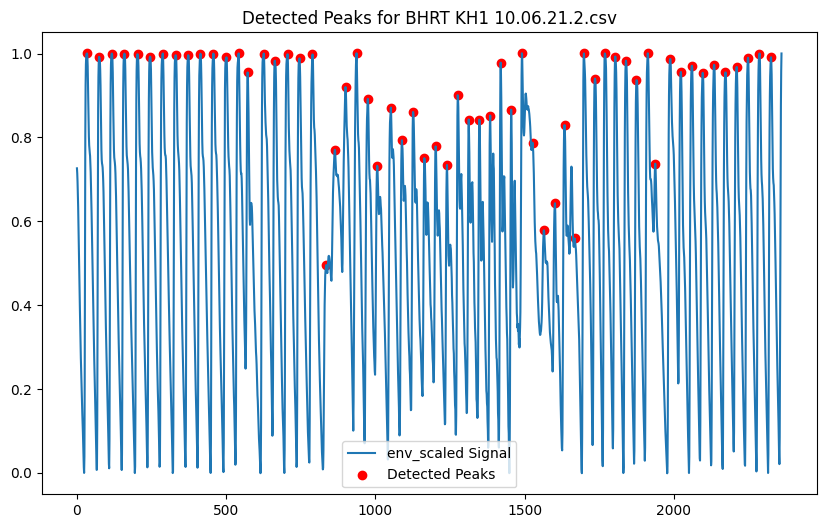

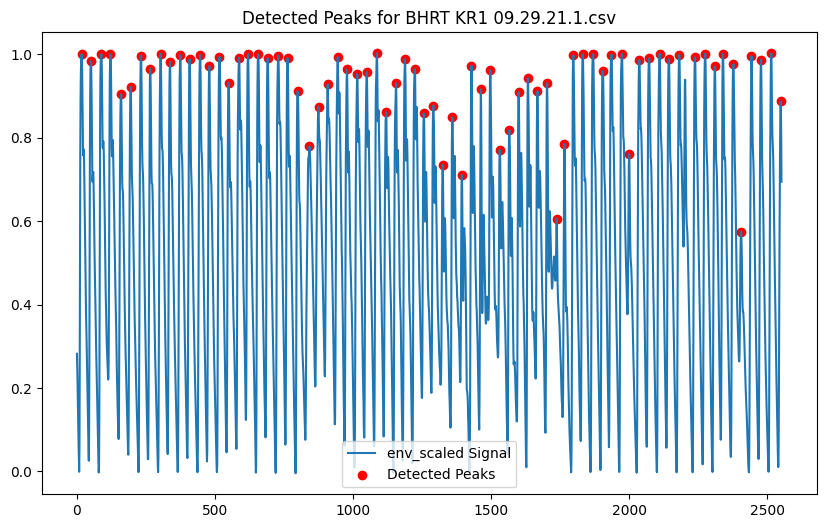

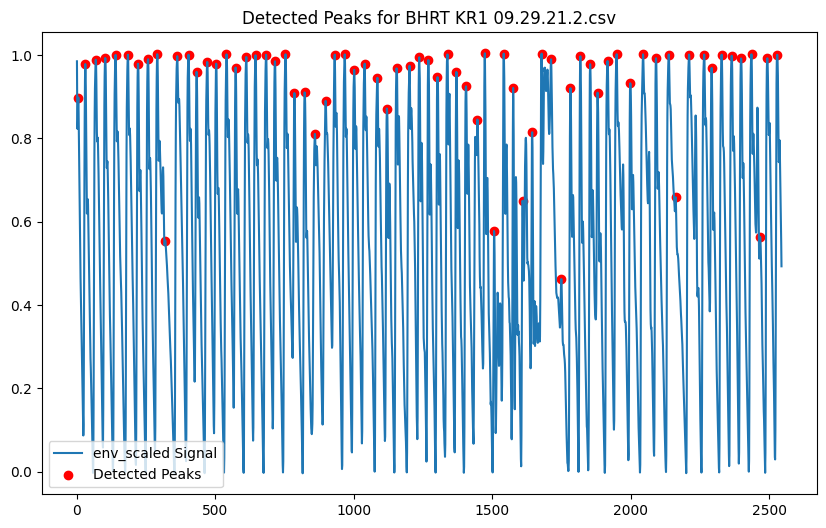

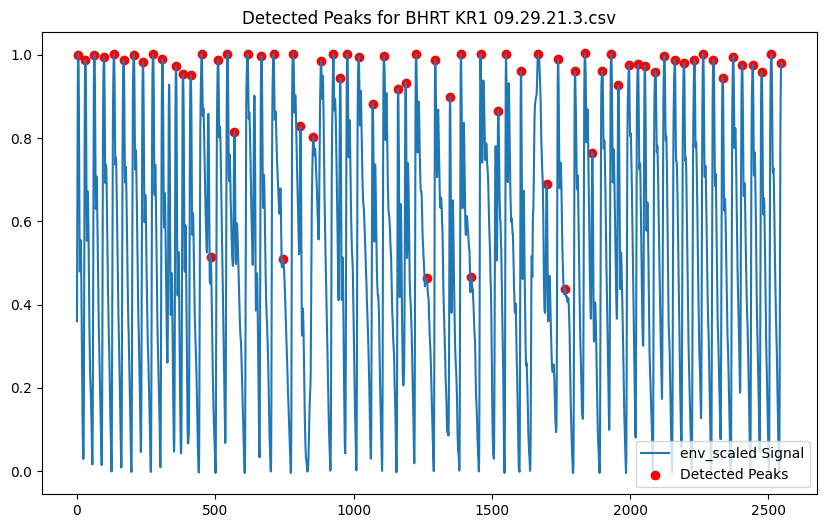

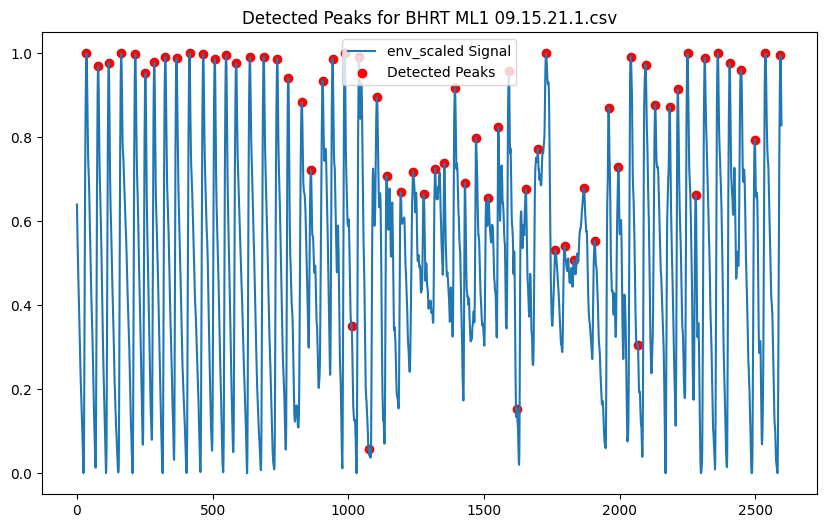

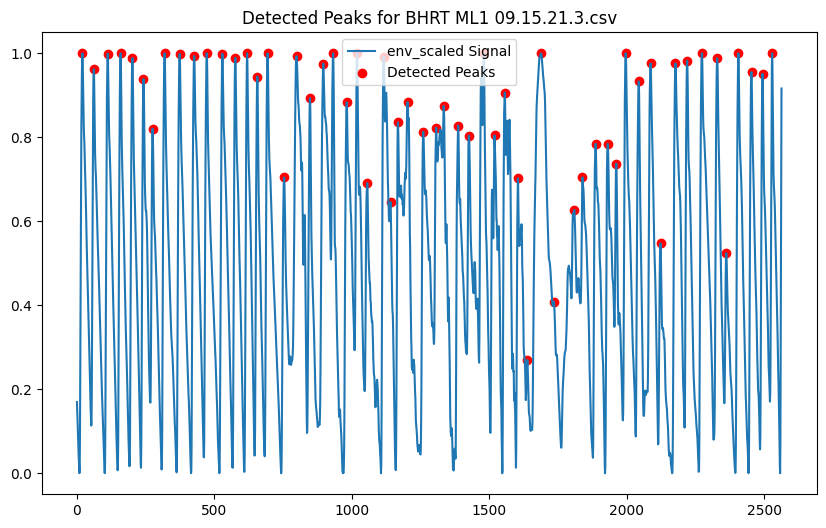

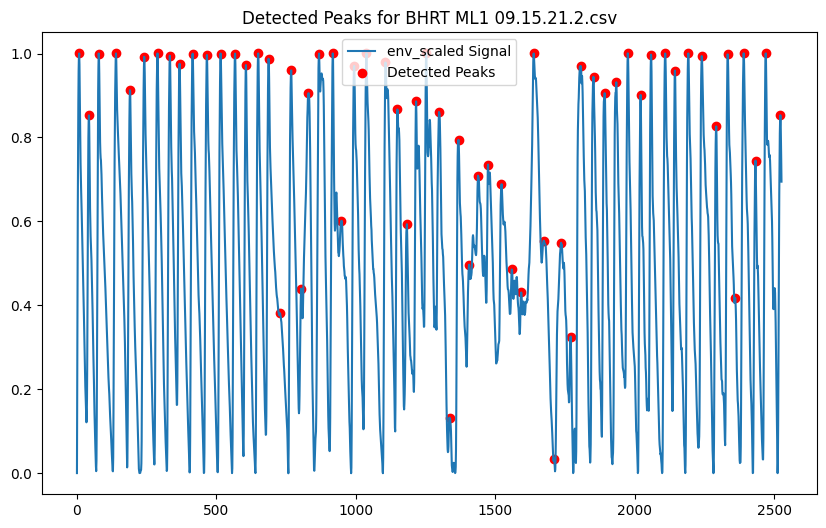

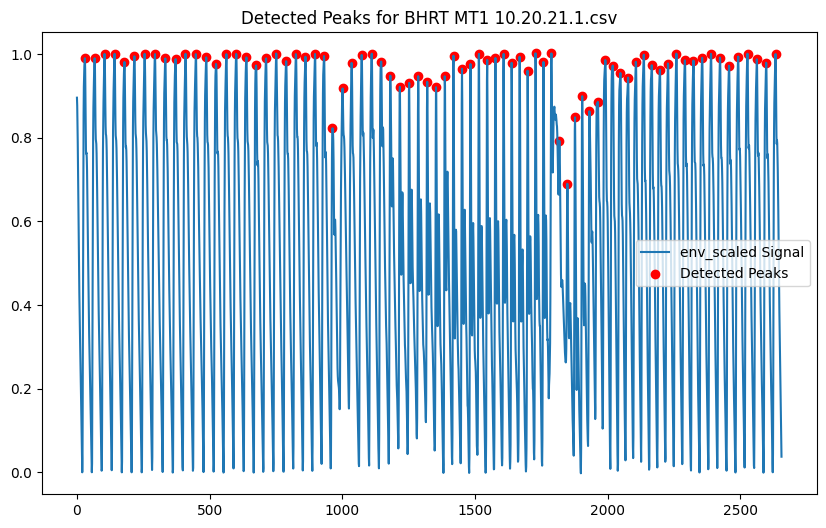

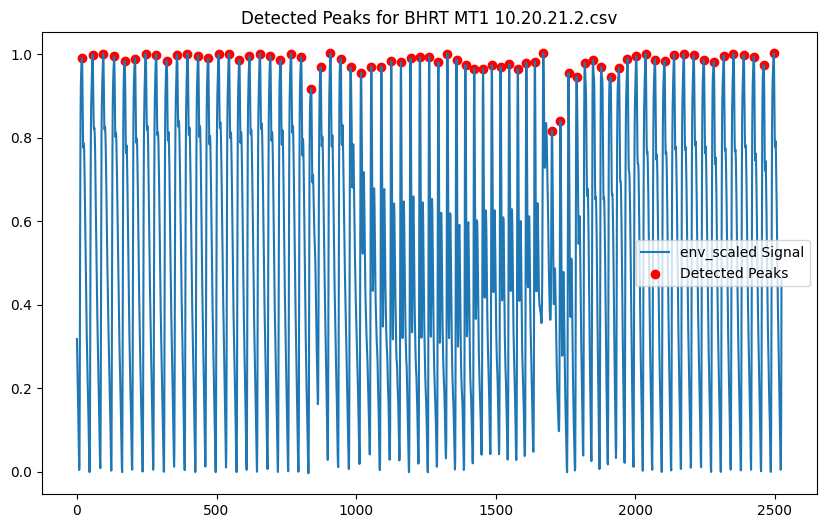

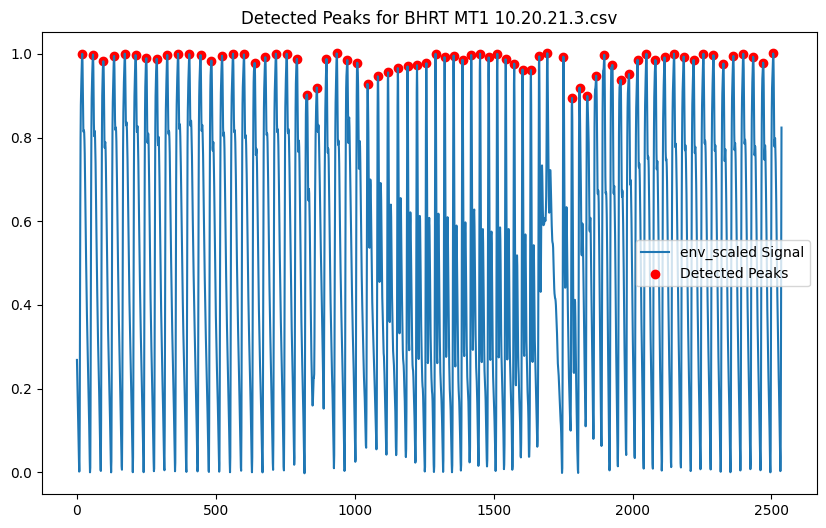

In [ ]:
for filename in selected_filenames:
    if filename not in ppg_signals_df:
        print(f"Warning: {filename} not found.")
        continue

    env_scaled = ppg_signals_df[filename]['env_scaled'].values

    # Detect peaks
    peaks, _ = scipy.signal.find_peaks(env_scaled, distance=25)

    # Debug: Plot detected peaks on the signal
    plt.figure(figsize=(10, 6))
    plt.plot(env_scaled, label='env_scaled Signal')
    plt.scatter(peaks, env_scaled[peaks], color='red', label='Detected Peaks')
    plt.legend()
    plt.title(f'Detected Peaks for {filename}')
    plt.show()


## Stretching Factor

Visualy ploting the distribution of the stretch and warp for a signal across all the heartbeats

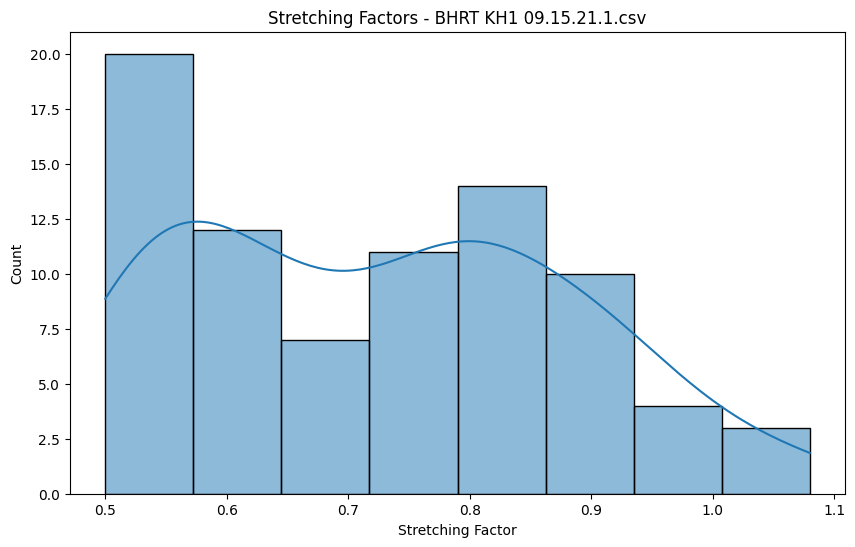

In [ ]:
# Plot stretching factors
plt.figure(figsize=(10, 6))
sns.histplot(example_factors, kde=True)
plt.title(f"Stretching Factors - {example_file}")
plt.xlabel("Stretching Factor")
plt.show()

## Multiple files

Multiple visuals for showing the orignal signals from the channel, the resampled signals, and the histograms for the stretching factors.

In [ ]:
num_files_to_visualize = 5
fig, axes = plt.subplots(num_files_to_visualize, 3, figsize=(24, 6 * num_files_to_visualize))

for idx, filename in enumerate(selected_filenames[:num_files_to_visualize]):
    if filename not in stretched_signals or filename not in stretching_factors:
        print(f"Warning: {filename} not processed.")
        continue

    # Original and resampled signals
    original_signal = ppg_signals_df[filename]['env_scaled'].values
    resampled_signal = stretched_signals[filename]
    factors = stretching_factors[filename]

    # Plot original signal
    axes[idx, 0].plot(original_signal, color='blue')
    axes[idx, 0].set_title(f"Original Signal - {filename}")
    axes[idx, 0].set_xlabel("Time (points)")
    axes[idx, 0].set_ylabel("Signal Amplitude")

    # Plot resampled signal
    axes[idx, 1].plot(resampled_signal, color='orange')
    axes[idx, 1].set_title(f"Resampled Signal - {filename}")
    axes[idx, 1].set_xlabel("Time (resampled points)")
    axes[idx, 1].set_ylabel("Signal Amplitude")

    # Plot stretching factors
    sns.histplot(factors, kde=True, ax=axes[idx, 2], color='green')
    axes[idx, 2].set_title(f"Stretching Factors - {filename}")
    axes[idx, 2].set_xlabel("Stretching Factor")
    axes[idx, 2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()